In [1]:
import sqlite3
import pandas as pd
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np

/Users/necatifurkancolak/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
desktop_path = os.path.expanduser("~/Desktop/hedging-against-turkish-inflation/notebooks/database_name.db")

if not os.path.isfile(desktop_path):
    raise FileNotFoundError(f"Database file not found at {desktop_path}")

conn = sqlite3.connect(desktop_path)

tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Tables in the database:")
print(tables)

Tables in the database:
      name
0      INF
1  STOCKEX
2      BTC
3     GOLD
4     BOND
5      HPI
6      CPI


In [3]:
df_stock = pd.read_sql_query("SELECT * from STOCKEX", conn)
df_gold = pd.read_sql_query("SELECT * from GOLD", conn)
df_bond = pd.read_sql_query("SELECT * from BOND", conn)
df_hpi = pd.read_sql_query("SELECT * from HPI", conn)
df_btc = pd.read_sql_query("SELECT * from BTC", conn)

In [4]:
df_gold

,Date,Price_Gold,gold_return_mo,gold_return_pa,real_return
0,2024-09,2634.58,0.052405,0.845842,0.836823
1,2024-08,2503.39,0.022794,0.310560,0.303837
2,2024-07,2447.6,0.051939,0.836068,0.825075
3,2024-06,2326.75,-0.000249,-0.002986,-0.010056
4,2024-05,2327.33,0.017968,0.238258,0.229042
...,...,...,...,...,...
76,2018-05,1298.51,-0.012833,-0.143575,-0.144657
77,2018-04,1315.39,-0.007612,-0.087619,-0.088734
78,2018-03,1325.48,0.005439,0.067254,0.066034
79,2018-02,1318.31,-0.019946,-0.214763,-0.215700


In [5]:
df_btc

,Date,Price_Bitcoin,btc_return_mo,btc_return_pa,real_return
0,2024-09,63785.09,0.081934,1.572833,1.560262
1,2024-08,58954.67,-0.086823,-0.663752,-0.665477
2,2024-07,64559.96,0.042888,0.655212,0.645302
3,2024-06,61904.96,-0.084658,-0.654060,-0.656513
4,2024-05,67630.41,0.129642,3.318071,3.285935
...,...,...,...,...,...
76,2018-05,7538.28,-0.187046,-0.916672,-0.916777
77,2018-04,9272.7,0.353183,36.694534,36.648452
78,2018-03,6852.51,-0.349735,-0.994284,-0.994291
79,2018-02,10538.02,0.057789,0.962400,0.960060


# Markowitz Portfolio:

In [6]:
stock_ret = df_stock["stock_return_pa"]
gold_ret = df_gold["real_return"]
bond_ret = df_bond["bond_return_pa"]
hpi_ret = df_hpi["TP KFE TR-1"]
btc_ret = df_btc["real_return"]

In [7]:
returns = pd.concat([stock_ret, gold_ret, bond_ret, hpi_ret,btc_ret], axis=1)
returns.columns = ["Stock", "Gold", "Bond", "HPI", "BTC"]

expected_returns = returns.mean()
cov_matrix = returns.cov()

In [8]:
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.random(len(expected_returns))
    weights /= np.sum(weights)
    weights_record.append(weights)
    
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    results[0, i] = portfolio_return
    results[1, i] = portfolio_volatility
    results[2, i] = portfolio_return / portfolio_volatility  # Sharpe Oranı

weights_record = np.array(weights_record)

In [10]:
from scipy.optimize import minimize

def neg_sharpe(weights, expected_returns, cov_matrix, risk_free_rate=0):
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio

constraints = {"type": "eq", "fun": lambda x: np.sum(x) - 1}
bounds = tuple((0, 1) for _ in range(len(expected_returns)))
initial_weights = np.array([0.25, 0.25, 0.25, 0.25, 0.25])

optimized = minimize(neg_sharpe, initial_weights, args=(expected_returns, cov_matrix), 
                     method="SLSQP", bounds=bounds, constraints=constraints)

optimal_weights = optimized.x
portfolio_return = np.dot(optimal_weights, expected_returns)
portfolio_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))

print("Optimal Weights:", optimal_weights)
print("Expected Portfolio Return:", portfolio_return)
print("Expected Portfolio Volatility:", portfolio_volatility)

Optimal Weights: [3.29687492e-03 1.08563323e-03 9.90062216e-01 5.32718321e-03
 2.28092322e-04]
Expected Portfolio Return: 0.1928690759315128
Expected Portfolio Volatility: 0.05512988248772218


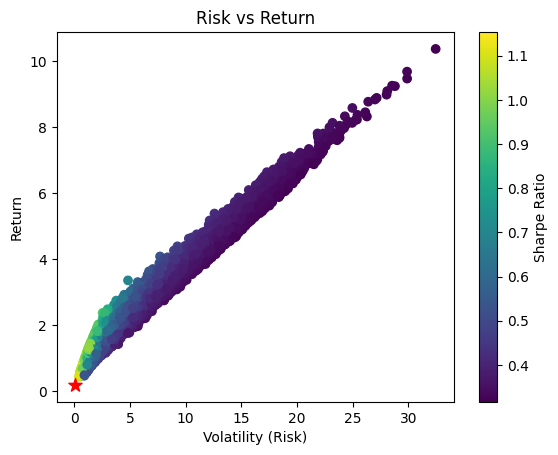

In [11]:
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap="viridis", marker="o")
plt.colorbar(label="Sharpe Ratio")
plt.scatter(portfolio_volatility, portfolio_return, color="red", marker="*", s=100)
plt.title("Risk vs Return")
plt.xlabel("Volatility (Risk)")
plt.ylabel("Return")
plt.show()